# Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
import numpy as np
import keras
import timeit
import matplotlib.pylab as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input


2022-09-15 01:20:53.074267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 01:20:53.238858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 01:20:53.238884: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-15 01:20:53.280195: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-15 01:20:53.986332: W tensorflow/stream_executor/platform/de

# Constant and function definitions

In [2]:
#Seeds
np.random.seed(0)
tf.random.set_seed(0)

#Constants
Nd = 101 #Collocation points in the domain
Nb = 1   #Collocation points in the boundary

#Computation of non-smooth distance function d:
def d(xs, xbs):
  #xs: List of collocation points
  #xbs: List of boundary conditions
  xs, xbs = np.array(xs), np.array(xbs)
  ds = [min([np.linalg.norm(x - xb) for xb in xbs]) for x in xs]
  return ds

def custom_loss(y_actual,y_pred):
    custom_loss=(0.5) * 1 / (Nb + Nd) * (y_actual-y_pred)**2
    return custom_loss

start = timeit.default_timer()

# Distance Model

In [3]:
N = 10
def build_model_distance(NUM_PERCEPTRONS):
  model_distance=tf.keras.Sequential([ 
    tf.keras.layers.Dense(NUM_PERCEPTRONS, activation='sigmoid',
                          input_shape=[None, 1], dtype='float64'
                          ),
    tf.keras.layers.Dense(NUM_PERCEPTRONS,
                          activation='sigmoid'
                          ),
    tf.keras.layers.Dense(1,
                          dtype='float64'
                          )
  ])

  optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)#tf.keras.optimizers.RMSprop(0.001)

  model_distance.compile(loss=custom_loss,
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model_distance

#Linear advection in 1D

The equation is given by:
\begin{align*}
Lu&=\frac{du}{dx}=f\\
u(0)&=g_0
\end{align*}

And taking the analytic solution as follows:
$$u = sin(2πx)cos(4πx)+1$$

Therefore, 
\begin{align*}
f(x) &= 2π(\cos(2\pi x)\cos(4\pi x)-2\sin(2\pi x)\sin(4\pi x))\\
g_0 &= 1
\end{align*}

So, the ansatz, $\hat{u}=\hat{u}(x;w,b)$, take the form:

$$u(x) = G(x) + D(x)y^L (x; w, b) $$

and the advection problem could be rewrite it as:
\begin{equation*}
\frac{dG(x)}{dx} + D(x)\frac{dy^L}{dx} + y^L\frac{dD(x)}{dx} = f
\end{equation*}


In [4]:
def u(x):
  return np.sin(2*np.pi*x)*np.cos(4*np.pi*x)+1
def f(x):
  return 2*np.pi*(np.cos(2*np.pi*x)*np.cos(4*np.pi*x)-2*np.sin(2*np.pi*x)*np.sin(4*np.pi*x))

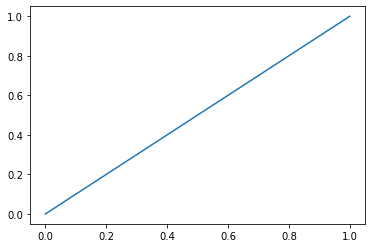

In [5]:
n = 100

xs = np.linspace(0,1,n)
ys = np.array(d(xs,[0]))
ys = ys/np.max(ys)
plt.plot(xs, ys)

In [6]:
N = 10
model_distance = build_model_distance(N)

train_size = 20

#Random set to train of train_size random points
train_set = np.sort(np.random.choice(len(xs)-2, size=train_size, replace=False))
x_train = xs[train_set+1].reshape(-1,1)
y_train = ys[train_set+1].reshape(-1,1)

model_distance.fit(x_train, y_train, epochs=1500, verbose=False)

2022-09-15 01:20:55.396901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 01:20:55.397197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 01:20:55.397242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-15 01:20:55.397282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-15 01:20:55.397321: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

4/4 [==============================] - 0s 1ms/step


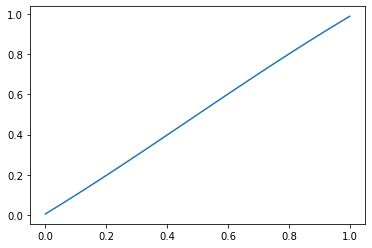

In [7]:
d = model_distance.predict(xs.reshape(-1,1)).reshape(-1)
plt.plot(xs,d)

## Using a derivative inside a loss function

In [8]:
#Define the model

inputs = Input(shape=(1,))
x = Dense(10, 'sigmoid', dtype='float64')(inputs)
x = Dense(10, 'sigmoid')(x)
x = Dense(10, 'sigmoid')(x)
y = Dense(1, dtype='float64')(x)
model = Model(inputs=inputs, outputs=y)

tf.keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
n = 100

def u(x):
    return np.sin(2*np.pi*x)*np.cos(4*np.pi*x)+1
def f(x):
    return 2*np.pi*(np.cos(2*np.pi*x)*np.cos(4*np.pi*x)-2*np.sin(2*np.pi*x)*np.sin(4*np.pi*x))
def D(x):
    return model_distance(x)
def G(x):
    return 1

4/4 [==============================] - 0s 1ms/step
Step 0: loss=4942.361824459184
Step 0: Error=1.0434042869865148


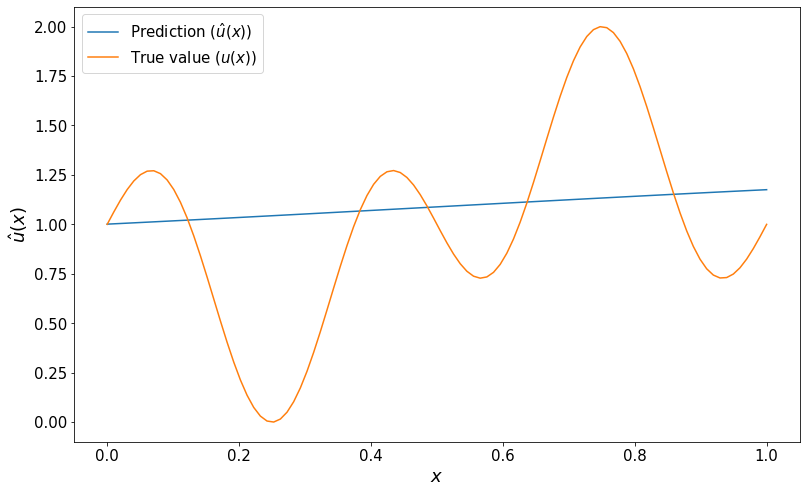

INFO:tensorflow:Assets written to: ../models/advection_model_100_samples/assets
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 994us/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 926us/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 961us/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 930us/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 902us/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 988us/step


4/4 [==============================] - 0s 1ms/step


In [ ]:
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)

num_samples = 100

#Random set to train of train_size random points
x_train = np.linspace(0.01,1-0.001,num_samples)
y_train = f(x_train)

# using the high level tf.data API for data handling
x_train = tf.reshape(x_train,(-1,1))
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(100)

xs = np.linspace(0,1,num_samples) # puntos donde evaluo el modelo, distintos de los de colocación.

# we need to convert x to a variable if we want the tape to be 
# able to compute the gradient according to x

x_variable = tf.Variable(x_train, dtype='float64') 
ff = tf.constant(f(x_variable))

with tf.GradientTape() as g:
    g.watch(x_variable)
    Dx = D(x_variable)
dD_dx = g.gradient(Dx, x_variable)

D_pred = D(x_variable)

n_train_steps = 10000

v_loss  = np.empty((n_train_steps,0))
v_error = np.empty((n_train_steps,0))
y_pred_old = np.zeros_like(x_variable)
for step in range(n_train_steps):
    with tf.GradientTape() as model_tape:
        with tf.GradientTape() as y_tape:
            y_tape.watch(x_variable)
            y_pred = model(x_variable)
        dy_dx = y_tape.gradient(y_pred, x_variable)
        y_pred_old = y_pred.numpy()
        lu = dD_dx.numpy()*y_pred + D_pred.numpy()*dy_dx
        loss = tf.reduce_sum(tf.math.squared_difference(lu, ff))
        v_loss = np.append(v_loss,loss)   
    grad = model_tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grad, model.trainable_variables))

    Yl = model.predict(xs.reshape(-1,1)).reshape(-1)
    Ds = [D(tf.constant([[x]])).numpy()[0][0][0] for x in xs]
    u_hat = G(xs)+Ds*Yl
    error = np.max(np.abs(u_hat-u(xs)))
    v_error = np.append(v_error, error)
    if step%2000==0: 
        print(f"Step {step}: loss={loss.numpy()}")
        print(f"Step {step}: Error={np.max(np.abs(u_hat-u(xs)))}")

        plt.figure(figsize=(13,8))
        plt.plot(xs, u_hat, label="Prediction ($\hat{u}(x)$)")
        plt.plot(xs, u(xs), label="True value ($u(x)$)")
        plt.xlabel(r"$x$", fontsize=18)
        plt.ylabel(r"$\hat{u}(x)$", fontsize=18)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(prop={'size': 15})
        plt.savefig(f"../graficas/advection_1D_{step}_solution.png")
        plt.show()
        '''
        fig, ([ax0, ax1, ax2], [ax3, ax4, ax5]) = plt.subplots(nrows=2, ncols=3, sharex=False,
                                    figsize=(24, 10))
        ax0.plot(xs, u_hat, label="Prediction ($\hat{u}(x)$)")
        ax0.plot(xs, u(xs), label="True value ($u(x)$)")
        ax0.set_xlim(0, 1)
        ax0.legend()

        ax1.semilogy(v_loss, label="Loss function")
        ax1.set_xlim(0, v_loss.shape[0])
        ax1.legend()

        ax2.plot(x_variable.numpy(), lu, label="Lu(x)")
        ax2.plot(x_variable.numpy(), ff, label="f(x)")
        ax2.set_xlim(0, 1)
        ax2.legend()

        ax3.plot(x_train,y_pred, label="y_pred")
        ax3.plot(x_variable[1:-1],(u(x_variable[1:-1])-G(x_variable[1:-1]))/tf.reshape(D(x_variable[1:-1]), [-1, 1]), label="y_exact")
        ax3.set_xlim(0, 1)
        ax3.legend()

        ax4.plot(x_variable.numpy(), dy_dx.numpy(), label="y_pred_x")
        ax4.legend()

        ax5.semilogy(v_error, label=r"$max(|\hat{u}(x) - u(x)|)$")
        ax5.set_xlim(0, v_error.shape[0])
        ax5.legend()
        plt.savefig(f"../graficas/advection_1D_{step}.png")
        plt.show()'''
        model.save(f"../models/advection_model_{num_samples}_samples")
plt.semilogy(v_error, label=r"$max(|\hat{u}(x) - u(x)|)$")
plt.title("Error evolution", fontsize=18)
plt.xlabel(r"$max(abs(\hat{u}(x) - u(x)))$", fontsize=18)
plt.ylabel(r"$u(x)$", fontsize=18)
plt.xlim(0, v_error.shape[0])
plt.legend(prop={'size': 15})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(f"../graficas/advection_1D_error_evolution.png")
plt.show()

Using the Relu/Selu activation function, which is not differentiable, the neural network is not able to fit the solution of the differential equation.
Tanh works but not is as precise as work with sigmoid function.

### Saving the model

In [ ]:
model.summary()

In [ ]:
model.save(f"../models/advection_model_{num_samples}_samples")

### Loading the model

In [ ]:
n = 100
num_samples = 10000
def u(x):
    return np.sin(2*np.pi*x)*np.cos(4*np.pi*x)+1
def f(x):
    return 2*np.pi*(np.cos(2*np.pi*x)*np.cos(4*np.pi*x)-2*np.sin(2*np.pi*x)*np.sin(4*np.pi*x))
def D(x):
    #return model_light.predict(x.numpy().reshape(-1,1)).reshape(-1)
    return x
def G(x):
    return 1

In [ ]:
model_path = f"../models/advection_model_{num_samples}_samples"
reconstructed_model = keras.models.load_model(model_path)

In [ ]:
reconstructed_model.summary()

In [ ]:
xs = np.linspace(0,1,n)
Yl = reconstructed_model.predict(xs.reshape(-1,1)).reshape(-1)
u_hat = G(xs)+D(xs)*Yl
plt.figure(figsize=(13,8))
plt.plot(xs, u_hat, label="Prediction ($\hat{u}(x)$)")
plt.plot(xs, u(xs), label="True value ($u(x)$)")
plt.legend()

In [ ]:
xs = np.linspace(0,1,n)

plt.figure(figsize=(13,8))
plt.plot(xs, abs(u_hat-u(xs)), label="Error: $|\hat{u}(x)-u(x)|$")
plt.xlabel(r"$x$", fontsize=18)
plt.ylabel(r"$|\hat{u}(x)-u(x)|$", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={'size': 15})
plt.savefig(f"../graficas/advection_1D_error.png")
plt.legend()

In [ ]:
stop = timeit.default_timer()
print('Time: ', stop - start) 

Time using CPU:  2568.511007819001